In [1]:
import os
import matplotlib.pyplot as plt
import cv2
import numpy as np
import json
import pandas as pd
import glob
from tqdm.auto import tqdm
import tensorflow as tf
from tensorflow import keras

In [2]:
object_detection_path = os.path.join('drive', 'MyDrive', 'data', 'object_detection')
semantic_segmentation_path = os.path.join('drive', 'MyDrive', 'data', 'semantic_segmentation')

##ROTATING IMAGES

In [3]:
image_path = os.path.join(object_detection_path, 'Baltic_Sea_full_mosaic', 'train')

Image padding and rotation

In [4]:
def rotate_image(image, angle):
  image_center = tuple(np.array(image.shape[1::-1]) / 2)
  rot_mat = cv2.getRotationMatrix2D(image_center, angle, 1.0)
  result = cv2.warpAffine(image, rot_mat, image.shape[1::-1], flags=cv2.INTER_NEAREST, borderValue=(255,255,255))
  return result, rot_mat

def padding(image):
  height = image.shape[0]
  width = image.shape[1]
  max = np.max((height, width)) + 800
  canvas = np.ones((max, max, 3)) * 255
  new_height = int((max - height) / 2)
  new_width = int((max - width) / 2)
  canvas[new_height:height + new_height, new_width: width + new_width,:] = image
  return canvas.astype('uint8')

image = cv2.imread(os.path.join(image_path, '7.tif'))
image_pad = padding(image)
rotated_image, rotation_matrix = rotate_image(image_pad, 87)
saving_path = os.path.join(object_detection_path, 'Baltic_Sea_full_mosaic')

#cv2.imwrite(os.path.join(saving_path, 'train', 'image7_rotated.png'), rotated_image)

#TRAINING

##Plot mosaic to check if the rotation angle used is the right plot and get bounding boxes coordinates after rotation

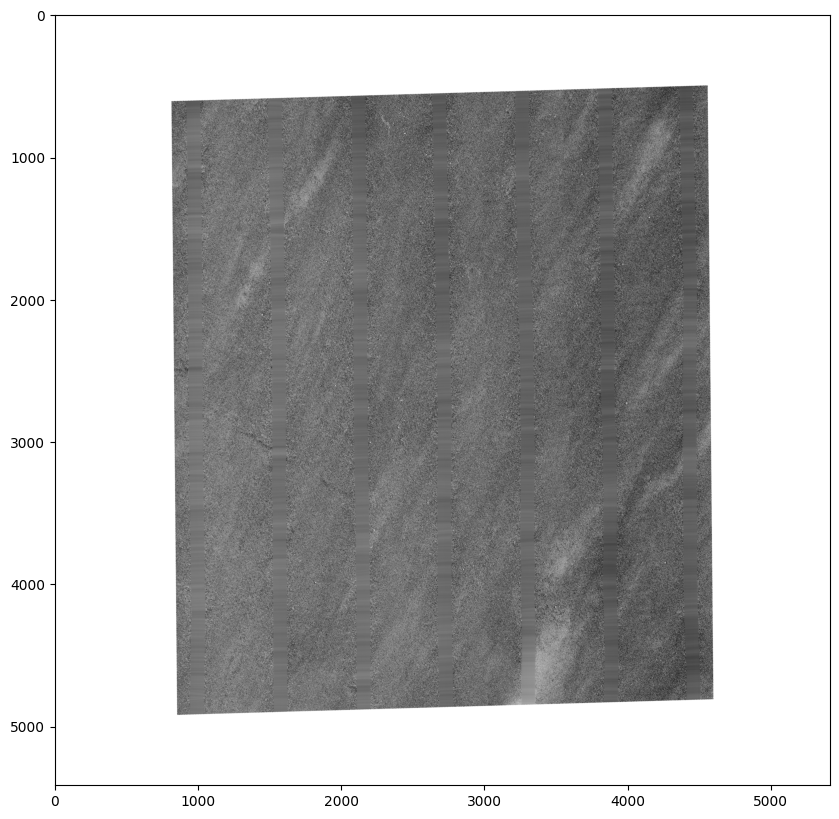

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
ax = plt.imshow(rotated_image, aspect='auto')

Boulders bounding boxes coordinates rotation

In [ ]:
def rotate_coordinates(coord, rot_mat, angle):
  x, y = coord[:, 1], coord[:, 2]
  width, height = coord[:, 3], coord[:, 4]
  ones = np.ones((coord.shape[0], 1))

  #bounding box
  p1 = np.array((x - width/2, y + height/2)).T #top left
  p2 = np.array((x + width/2, y + height/2)).T #top right
  p3 = np.array((x - width/2, y - height/2)).T #bottom left
  p4 = np.array((x + width/2, y - height/2)).T #bottom right

  new_labels = np.copy(coord)
  new_labels[:,1:] = 0

  #rotating center coordinate of bounding box
  new_labels[:,1:3] = np.dot(rot_mat, np.array((x, y, ones[:,0]))).T

  #rotating bounding box
  rotated_bounding_box_p1 = np.dot(rot_mat, np.array((p1[:,0], p1[:,1], ones[:,0]))).T
  rotated_bounding_box_p2 = np.dot(rot_mat, np.array((p2[:,0], p2[:,1], ones[:,0]))).T
  rotated_bounding_box_p3 = np.dot(rot_mat, np.array((p3[:,0], p3[:,1], ones[:,0]))).T
  rotated_bounding_box_p4 = np.dot(rot_mat, np.array((p4[:,0], p4[:,1], ones[:,0]))).T

  #getting new width and height for bounding box after rotation
  for i in range(coord.shape[0]):
    x_max = np.max((rotated_bounding_box_p1[i,0], rotated_bounding_box_p2[i,0], rotated_bounding_box_p3[i,0], rotated_bounding_box_p4[i,0]))
    x_min = np.min((rotated_bounding_box_p1[i,0], rotated_bounding_box_p2[i,0], rotated_bounding_box_p3[i,0], rotated_bounding_box_p4[i,0]))
    y_max = np.max((rotated_bounding_box_p1[i,1], rotated_bounding_box_p2[i,1], rotated_bounding_box_p3[i,1], rotated_bounding_box_p4[i,1]))
    y_min = np.min((rotated_bounding_box_p1[i,1], rotated_bounding_box_p2[i,1], rotated_bounding_box_p3[i,1], rotated_bounding_box_p4[i,1]))
    new_labels[i,3:] = np.array((x_max-x_min, y_max-y_min))

  #new_labels[:,3:] = np.dot(rot_mat, np.array((width, height, ones[:,0]))).T

  return new_labels

boulders_boxes = np.loadtxt(os.path.join(image_path, '7.txt'))

boulders_boxes[:,1] *= image.shape[1]
boulders_boxes[:,2] *= image.shape[0]
boulders_boxes[:,3] *= image.shape[1]
boulders_boxes[:,4] *= image.shape[0]
boulders_boxes_after_padding = np.copy(boulders_boxes)
boulders_boxes_after_padding[:,1] += int((rotated_image.shape[1] - image.shape[1]) / 2)
boulders_boxes_after_padding[:,2] += int((rotated_image.shape[0] - image.shape[0]) / 2)
boulders_boxes_after_rotation = rotate_coordinates(boulders_boxes_after_padding, rotation_matrix, 87)

In [ ]:
boulders_boxes_after_rotation[184]

array([  15.        , 1160.49086487, 4661.06336587,   19.00235269,
         16.21697043])

##Convert JSON file from LABELME format to YOLO format

In [ ]:
import json

In [ ]:
#Dictionary with the labels of each polygon
segments = {
    "front": 0,
    "shadow": 1
}

file_path = os.path.join('drive', 'MyDrive', 'data', 'semantic_segmentation', 'Baltic_Sea', 'boulder_height', 'YOLOv8')
file_list = os.listdir(os.path.join(file_path, 'labels', 'train'))

for file_name in file_list:
  if file_name.endswith('.json'):
    file_number = os.path.splitext(file_name)[0]

    f = open(os.path.join(file_path, 'labels', 'train', file_name))

    data = json.load(f)

    file = open(os.path.join(file_path, 'labels', 'train', file_number + '.txt'), 'w')

    image = cv2.imread(os.path.join(file_path, 'images', 'train', file_number + '.png'))
    shape_y = image.shape[0]
    shape_x = image.shape[1]

    for i in data['shapes']:
      points = np.array(i['points'])
      label = segments[i['label']]
      file.write("%i " %(label))
      for a in range(points.shape[0]):
        normalized_points = np.array(points[a,:])
        normalized_points[0] = normalized_points[0] / shape_x
        normalized_points[1] = normalized_points[1] / shape_y
        #normalized_points = np.array(points[a,1::2] / shape_x)
        file.write("%f %f " %(normalized_points[0], normalized_points[1]))
      file.write("\n")
    file.close()

##Semantic Segmentation for NADIR detection using YOLOV8

In [ ]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.153 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/107.7 GB disk)


In [ ]:
from ultralytics import YOLO

In [ ]:
# Load a model
model = YOLO('yolov8n-seg.pt')  # load a pretrained model (recommended for training)

100%|██████████| 6.73M/6.73M [00:00<00:00, 70.2MB/s]


TRAIN THE MODEL

In [ ]:
#os.environ["PYTHONPATH"]="/content/drive/MyDrive/data/semantic_segmentation/YOLOv8"

yaml_path = os.path.join('drive', 'MyDrive', 'data', 'semantic_segmentation', 'Baltic_Sea', 'YOLODataset')

# Train the model
model.train(data=os.path.join(yaml_path, 'dataset.yaml'), pretrained=True, epochs=200, imgsz=1280, iou=0.4, visualize=True, project='/content/drive/MyDrive/data/semantic_segmentation/YOLOv8')
#model.train(data=coco128-seg.yaml, epochs=10, imgsz=640)

Ultralytics YOLOv8.0.150 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (Intel Xeon 2.20GHz)
engine/trainer: task=segment, mode=train, model=yolov8n-seg.pt, data=drive/MyDrive/data/semantic_segmentation/Baltic_Sea/YOLODataset/dataset.yaml, epochs=200, patience=50, batch=16, imgsz=1280, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/data/semantic_segmentation/YOLOv8, name=None, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.4, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=True, augment=False, agnostic_nms=False, classes=None,

EVALUATE THE RESULTS IN THE VALIDATION IMAGES

In [ ]:
model.val()

Ultralytics YOLOv8.0.149 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (Intel Xeon 2.20GHz)
YOLOv8n-seg summary (fused): 195 layers, 3258259 parameters, 0 gradients
val: Scanning /content/drive/MyDrive/data/semantic_segmentation/Baltic_Sea/YOLODataset/labels/val.cache... 1 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1/1 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 1/1 [00:05<00:00,  5.11s/it]
                   all          1          7      0.517      0.767      0.568      0.155      0.895      0.714      0.897      0.331
Speed: 9.6ms preprocess, 2088.6ms inference, 0.0ms loss, 157.4ms postprocess per image
Results saved to runs/segment/val


ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ee117612470>
fitness: 0.5837176989609736
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'metrics/precision(M)', 'metrics/recall(M)', 'metrics/mAP50(M)', 'metrics/mAP50-95(M)']
maps: array([    0.48572])
names: {0: 'nadir'}
plot: True
results_dict: {'metrics/precision(B)': 0.5168257353486356, 'metrics/recall(B)': 0.7671665968099978, 'metrics/mAP50(B)': 0.5683001443001443, 'metrics/mAP50-95(B)': 0.1550020676088617, 'metrics/precision(M)': 0.8947986244737661, 'metrics/recall(M)': 0.7142857142857143, 'metrics/mAP50(M)': 0.8974242424242422, 'metrics/mAP50-95(M)': 0.33071488826728823, 'fitness': 0.5837176989609736}
save_dir: PosixPath('runs/segment/val')
seg: ultralytics.utils.metrics.Metric object
speed: {'preprocess': 9.55700874328613

PREDICT RESULTS IN NEVER BEFORE SEEN DATA (TEST DATA)

In [ ]:
model = YOLO(os.path.join(semantic_segmentation_path, 'YOLOv8', 'train2', 'weights', 'best.pt'))

In [ ]:
#val_path = os.path.join('drive', 'MyDrive', 'data', 'semantic_segmentation', 'Baltic_Sea', 'YOLODataset', 'images', 'train')
#image = cv2.imread(os.path.join(image_path, '1.tif'))
results = model.predict(source=rotated_image, save=True, save_txt=True, iou=0.8, conf=0.2,
                        project='/content/drive/MyDrive/data/semantic_segmentation/YOLOv8', name='image7_iou0.8_conf0.2')


0: 1280x1280 37 nadirs, 1964.5ms
Speed: 41.4ms preprocess, 1964.5ms inference, 1263.1ms postprocess per image at shape (1, 3, 1280, 1280)
Results saved to /content/drive/MyDrive/data/semantic_segmentation/YOLOv8/image7_iou0.8_conf0.2
1 label saved to /content/drive/MyDrive/data/semantic_segmentation/YOLOv8/image7_iou0.8_conf0.2/labels


##Getting NADIR coordinates from semantic segmentation and creating tiles

In [ ]:
nadir_labels_path = os.path.join(semantic_segmentation_path, 'YOLOv8')

#image = cv2.imread(os.path.join(nadir_labels_path, 'image7_iou0.8_conf0.42', 'image0.jpg'))
shape = rotated_image.shape[0] #read the image from the predict cell, which doesn't contain the nadir labels

file = open(os.path.join(nadir_labels_path, 'image7_iou0.8_conf0.2/labels/image0.txt'))

nadir_coord = []

for i in file:
    nadir_labels = np.array(i.split(), dtype=float)
    nadir_labels = nadir_labels[1:] * shape
    x_max = np.max(nadir_labels[::2])
    x_min = np.min(nadir_labels[::2])
    x_mean = np.mean((x_max, x_min))
    nadir_coord.append(x_mean)

segments_center = np.sort(np.asarray(nadir_coord))
# In case there are multiple segments that belong to the same Nadir we average the nadir center value
nadir_center = []
i = 0
for id in np.argwhere(np.diff(segments_center) > 50):
  if id == i:
    nadir_center.append(segments_center[int(id)])
    i = int(id) + 1
  else:
    nadir_center.append(np.mean(segments_center[i:int(id)]))
    i = int(id) + 1
nadir_center.append(np.mean((segments_center[i:-1])))

In [ ]:
nadir_center

[761.525664,
 1266.165664,
 1724.325664,
 2131.025664,
 2602.7423306666665,
 3148.6056639999997,
 3605.312168,
 4022.1805311999997,
 4481.585664]

Separate left and right data from Nadir and create tiles

In [ ]:
destiny_folder = os.path.join(object_detection_path, 'tiles_for_train', '40x40', 'Baltic_Sea', 'images', 'val')

def create_tiles(line, tile_size, overlapping, starting_column, text): #the overlapping must be supplied in pixels
  for row in range(0, line.shape[0]-tile_size, tile_size - overlapping): #rows
    for column in range(0, line.shape[1]-tile_size, tile_size - overlapping): #columns
      tile = line[row:row+tile_size, column:column+tile_size, :]
      if text == 'flipped':
        tile = np.flip(tile, axis=1) # flip left data horizontally
      #For training, we need to save the tiles into a folder, later on (when detecting) this lines below can be omitted
      zero_pixels = len(np.nonzero(np.logical_and(tile[:,:,0] == 255, tile[:,:,1] == 255, tile[:,:,2] == 255))[0])
      if zero_pixels < tile_size*tile_size:
        tile_row = 'row_'
        tile_column = 'column_'
        file_name = '%s%i_%s%i_mosaic%i_%s.png' % (tile_row, row, tile_column, column+starting_column, 7, text)
        cv2.imwrite(os.path.join(destiny_folder, file_name), tile)
  return None

In [ ]:
initial = 0
tile_size = 160 #tile size is 160 pixels = 40 m (0.25m resolution), and overlapping 4 pixels = 1 m
for number in range(len(nadir_center)):
  try:
    middle = int(np.mean((nadir_center[number], nadir_center[number+1])))

    left_data = np.copy(rotated_image[:,initial:int(nadir_center[number]),:])
    create_tiles(left_data, tile_size, 4, initial, 'flipped')

    right_data = np.copy(rotated_image[:,int(nadir_center[number]):middle,:])
    create_tiles(right_data, tile_size, 4, int(nadir_center[number]), 'normal')
    initial=middle+1
  except:
    IndexError

##Assigning the boulder labels of each tile

Saving labels of each tile created

In [ ]:
tile_size = 160 #Because the mosaic resolution is 0.25m, so this makes it a 40x40m tile
tile_row = 'row_'
tile_column = 'column_'

tiles_folder = os.path.join(object_detection_path, 'tiles_for_train', '40x40', 'Baltic_Sea', 'images', 'val')
#directory_list = os.listdir(tiles_folder)
tiles_directory_list = glob.glob(os.path.join(tiles_folder,'*.png'))

for tile in tiles_directory_list:
  splitted = os.path.splitext(tile.split("/")[9])[0].split("_")
  row = int(splitted[1])
  column = int(splitted[3])
  if splitted[4] == 'mosaic7':
    for boulder_number in range(boulders_boxes_after_rotation.shape[0]):
      x = boulders_boxes_after_rotation[boulder_number, 1]
      y = boulders_boxes_after_rotation[boulder_number, 2]
      width = boulders_boxes_after_rotation[boulder_number, 3]
      height = boulders_boxes_after_rotation[boulder_number, 4]
      label  = np.ones((1, 5))
      if (x - width/2 >= column) & (x + width/2 <= column + tile_size):
        if (y - height/2 >= row) & (y + height/2 <= row + tile_size):
          if splitted[5] == 'flipped':
            new_x = (tile_size - x + column) / tile_size #Since this tile is flipped, I need to add the tile size to place the bbox in the right position
          else:
            new_x = (x - column) / tile_size # X position within the tile on a 1.0 scale
          new_y = (y - row) / tile_size # Y position within the tile on a 1.0 scale
          new_width = width / tile_size
          new_height = height / tile_size
          label[0,:] = 15, new_x, new_y, new_width, new_height
          tile_labels = pd.DataFrame(data = label)
          try:
            for new_boulder_number in range(boulder_number+1, boulders_boxes_after_rotation.shape[0]):
              x = boulders_boxes_after_rotation[new_boulder_number, 1]
              y = boulders_boxes_after_rotation[new_boulder_number, 2]
              width = boulders_boxes_after_rotation[new_boulder_number, 3]
              height = boulders_boxes_after_rotation[new_boulder_number, 4]
              if (x - width/2 >= column) & (x + width/2 <= column + tile_size):
                if (y - height/2 >= row) & (y + height/2 <= row + tile_size):
                  if splitted[5] == 'flipped':
                    new_x = (tile_size - x + column) / tile_size #This tile is horizontally flipped, we need to add the tile size to place the bbox in the right position
                  else:
                    new_x = (x - column) / tile_size # X position within the tile on a 1.0 scale
                  new_y = (y - row) / tile_size # Y position within the tile on a 1.0 scale
                  new_width = width / tile_size
                  new_height = height / tile_size
                  tile_labels.loc[len(tile_labels.index)] = [15, new_x, new_y, new_width, new_height]
          except:
            IndexError
          label_file_name = '%s.txt' % (os.path.splitext(tile.split("/")[9])[0])
          #label_file_name = '%s%i_%s%i_mosaic1_%s.txt' % (tile_row, row, tile_column, column)
          tile_labels = tile_labels.round(decimals=6)
          tile_labels.to_csv(os.path.join(tiles_folder, label_file_name), header=False, index=False, sep=' ')
          break
        else:
          pass
      else:
        pass

In [ ]:
directory_list = os.listdir(tiles_folder)
print(len(directory_list))
aaa = glob.glob(os.path.join(tiles_folder,'*.txt'))
len(aaa)

489


142

##Removing tiles that don't contain boulders from training folder

In [ ]:
tiles_folder = os.path.join(object_detection_path,
                            'tiles_for_train', '40x40', 'Baltic_Sea', 'images', 'val')
files = glob.glob(os.path.join(tiles_folder,'*.txt'))
len(files)
file_names = []
for i in range(len(files)-1):
  file_names.append(os.path.splitext(files[i].split("/")[9])[0])

In [ ]:
for file in os.listdir(tiles_folder):
    if file.endswith(".png"):
        try:
          if file_names.index(os.path.splitext(file)[0]):
            pass
        except:
          ValueError
          os.remove(os.path.join(tiles_folder, file))

Moving label txt files to label folder

In [ ]:
labels_folder = os.path.join(object_detection_path,
                            'tiles_for_train', '40x40', 'Baltic_Sea', 'labels', 'val')
for file in os.listdir(tiles_folder):
    if file.endswith(".txt"):
      os.replace(os.path.join(tiles_folder, file), os.path.join(labels_folder, file))

In [ ]:
lbls = []
imgs = []
for label in os.listdir(labels_folder):
  lbls.append(os.path.splitext(label)[0])
for img in os.listdir(tiles_folder):
  imgs.append(os.path.splitext(img)[0])
list(set(lbls) - set(imgs))
for label in list(set(lbls) - set(imgs)):
  os.remove(os.path.join(labels_folder, (label + '.txt')))

In [ ]:
print(len(os.listdir(labels_folder)))
print(len(os.listdir(tiles_folder)))

141
141


##OBJECT DETECTION TRAINING

##YoloV8

In [ ]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.162 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (Intel Xeon 2.20GHz)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/107.7 GB disk)


In [ ]:
from ultralytics import YOLO

In [ ]:
# Load a model
model = YOLO('yolov8x.pt')  # load a pretrained model (recommended for training)

100%|██████████| 131M/131M [00:00<00:00, 361MB/s]


Train the model

In [ ]:
yaml_path = os.path.join(object_detection_path, 'tiles_for_train', '40x40', 'Baltic_Sea')

# Train the model
model.train(data=os.path.join(yaml_path, 'dataset.yaml'), pretrained=True, batch=12, cache=True, save=True, epochs=50, project='/content/drive/MyDrive/data/object_detection/YOLOv8', name='40x40_yolov8x_model_batch12_50epoch_', patience=0)
#model.train(data=coco128-seg.yaml, epochs=10, imgsz=640)

Ultralytics YOLOv8.0.157 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=drive/MyDrive/data/object_detection/tiles_for_train/40x40/Baltic_Sea/dataset.yaml, epochs=50, patience=0, batch=12, imgsz=640, save=True, save_period=-1, cache=True, device=None, workers=8, project=/content/drive/MyDrive/data/object_detection/YOLOv8, name=40x40_yolov8x_model_batch12_50epoch_, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=

Evaluate the model in validation images

In [ ]:
model.val()

Ultralytics YOLOv8.0.157 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (Intel Xeon 2.20GHz)
100%|██████████| 755k/755k [00:00<00:00, 15.1MB/s]
val: Scanning /content/drive/MyDrive/data/object_detection/tiles_for_train/20x20/Baltic_Sea/labels/val.cache... 252 images, 0 backgrounds, 0 corrupt: 100%|██████████| 252/252 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 16/16 [24:33<00:00, 92.07s/it]
                   all        252        317      0.779      0.747      0.817       0.36
               boulder        252        317      0.779      0.747      0.817       0.36
Speed: 8.5ms preprocess, 5825.4ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/val


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([15])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7b457aa48850>
fitness: 0.4058353980663657
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)']
maps: array([    0.36016,     0.36016,     0.36016,     0.36016,     0.36016,     0.36016,     0.36016,     0.36016,     0.36016,     0.36016,     0.36016,     0.36016,     0.36016,     0.36016,     0.36016,     0.36016])
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'airplane', 4: 'bus', 5: 'train', 6: 'boat', 7: 'traffic light', 8: 'fire hydrant', 9: 'stop sign', 10: 'parking meter', 11: 'bench', 12: 'bird', 13: 'cat', 14: 'dog', 15: 'boulder'}
plot: True
results_dict: {'metrics/precision(B)': 0.7794069284477858, 'metrics/recall(B)': 0.7467739061717806, 'metrics/mAP50(B)': 0.8169480329999228, 'metrics/mAP50-95(B)': 0.36015621640708156, 'fitnes

Predict results in never before seen data (test data)

In [ ]:
model = YOLO(os.path.join(object_detection_path, 'YOLOv8', 'yolov8x_model_batch12_100epoch_2', 'weights', 'best.pt'))

In [ ]:
images = os.listdir(os.path.join(object_detection_path, 'tiles_for_train', '20x20', 'Baltic_Sea', 'images', 'val'))

In [ ]:
image = cv2.imread(os.path.join(object_detection_path, 'tiles_for_train', '20x20', 'Baltic_Sea', 'images', 'val', images[100]))
#image_np = np.asarray(image)

In [ ]:
results = model(image, save=True, save_txt=True, iou=0.5, show_labels=False)#, show=True)#,
                #project='/content/drive/MyDrive/data/object_detection/YOLOv8', name='PREDICT_20x20_image1_iou0.9_conf0.25')


0: 640x640 2 boulders, 6234.9ms
Speed: 9.5ms preprocess, 6234.9ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/predict
1 label saved to runs/detect/predict/labels


In [ ]:
# View results
for r in results:
    print(r.boxes.xywhn.numpy())

[[    0.88236     0.14736     0.22239     0.21746]
 [    0.94061     0.30365     0.11816     0.17665]]


In [ ]:
!yolo detect predict model='drive/MyDrive/data/object_detection/YOLOv8/yolov8x_model_batch12_100epoch_2/weights/best.pt' source='drive/MyDrive/data/object_detection/tiles_for_train/20x20/Baltic_Sea/images/val/row_3116_column_2292_mosaic7_normal.png' hide_labels=True imgsz=80 # predict with custom model

WARNING ⚠️ 'hide_labels' is deprecated and will be removed in 'ultralytics 8.2' in the future. Please use 'show_labels' instead.
Ultralytics YOLOv8.0.158 🚀 Python-3.10.12 torch-2.0.1+cu118 CPU (Intel Xeon 2.20GHz)
Model summary (fused): 268 layers, 68138976 parameters, 0 gradients

WARNING ⚠️ imgsz=[80] must be multiple of max stride 32, updating to [96]
image 1/1 /content/drive/MyDrive/data/object_detection/tiles_for_train/20x20/Baltic_Sea/images/val/row_3116_column_2292_mosaic7_normal.png: 96x96 (no detections), 262.0ms
Speed: 4.2ms preprocess, 262.0ms inference, 0.9ms postprocess per image at shape (1, 3, 96, 96)
Results saved to runs/detect/predict3


##SEMANTIC SEGMENTATION FOR MEASURING SHADOW LENGHT

##Training with YOLOV8

In [3]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.180 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/78.2 GB disk)


In [4]:
from ultralytics import YOLO

In [12]:
# Load a model
model = YOLO('yolov8m-seg.pt')  # load a pretrained model (recommended for training)

Train the model

In [13]:
yaml_path = os.path.join('drive', 'MyDrive', 'data', 'semantic_segmentation', 'Baltic_Sea', 'boulder_height', 'YOLOv8')

# Train the model
model.train(data=os.path.join(yaml_path, 'dataset.yaml'), pretrained=True, epochs=200, iou=0.6, visualize=True, save=True, imgsz=64,
            project='/content/drive/MyDrive/data/semantic_segmentation/YOLOv8/boulder_height',
            name='yolov8m_model_iou06_200epoch_imgsz64_optAdamW)')

Ultralytics YOLOv8.0.180 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=segment, mode=train, model=yolov8m-seg.pt, data=drive/MyDrive/data/semantic_segmentation/Baltic_Sea/boulder_height/YOLOv8/dataset.yaml, epochs=200, patience=50, batch=16, imgsz=32, save=True, save_period=-1, cache=False, device=None, workers=8, project=/content/drive/MyDrive/data/semantic_segmentation/YOLOv8/boulder_height, name=yolov8m_model_iou06_200epoch_imgsz32_optAdamW), exist_ok=False, pretrained=True, optimizer=AdamW, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.6, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1,

ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7ff560618ee0>
fitness: 0.00610592569564498
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'metrics/precision(M)', 'metrics/recall(M)', 'metrics/mAP50(M)', 'metrics/mAP50-95(M)']
maps: array([  0.0067143,   0.0019418])
names: {0: 'front', 1: 'shadow'}
plot: True
results_dict: {'metrics/precision(B)': 0.00625, 'metrics/recall(B)': 0.4, 'metrics/mAP50(B)': 0.011406465786473875, 'metrics/mAP50-95(B)': 0.0018852639117196486, 'metrics/precision(M)': 0.005625, 'metrics/recall(M)': 0.36, 'metrics/mAP50(M)': 0.010700255386410815, 'metrics/mAP50-95(M)': 0.0024427956197875856, 'fitness': 0.00610592569564498}
save_dir: PosixPath('/content/drive/MyDrive/data/semantic_segmentation/YOLOv8/boulder_height/yolov8m_model_iou06_200epoch_imgsz32_opt

Evaluate the results in the validation images

In [ ]:
model.val()

Ultralytics YOLOv8.0.178 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
YOLOv8l-seg summary (fused): 295 layers, 45913430 parameters, 0 gradients
val: Scanning /content/drive/MyDrive/data/semantic_segmentation/Baltic_Sea/boulder_height/YOLOv8/labels/val.cache... 50 images, 0 backgrounds, 0 corrupt: 100%|██████████| 50/50 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Mask(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:05<00:00,  1.33s/it]
                   all         50        100      0.519      0.557      0.478      0.138      0.487      0.498       0.37     0.0914
                 front         50         50      0.581      0.554       0.46       0.12      0.498      0.437      0.307     0.0701
                shadow         50         50      0.457       0.56      0.496      0.157      0.476       0.56      0.432      0.113
Speed: 6.8ms preprocess, 51.8ms inference, 0.0ms loss, 3.9ms post

ultralytics.utils.metrics.SegmentMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fb653692020>
fitness: 0.29148133458699693
keys: ['metrics/precision(B)', 'metrics/recall(B)', 'metrics/mAP50(B)', 'metrics/mAP50-95(B)', 'metrics/precision(M)', 'metrics/recall(M)', 'metrics/mAP50(M)', 'metrics/mAP50-95(M)']
maps: array([    0.18973,     0.26974])
names: {0: 'front', 1: 'shadow'}
plot: True
results_dict: {'metrics/precision(B)': 0.5188752713848904, 'metrics/recall(B)': 0.5572492982634885, 'metrics/mAP50(B)': 0.477666132371383, 'metrics/mAP50-95(B)': 0.13831996642490235, 'metrics/precision(M)': 0.48691309144072553, 'metrics/recall(M)': 0.49845198744639563, 'metrics/mAP50(M)': 0.3695670212808452, 'metrics/mAP50-95(M)': 0.09141116604373554, 'fitness': 0.29148133458699693}
save_dir: PosixPath('/content/drive/MyDrive/data/semantic_segmentation/YOLOv8/boulder_heig

Predict results in never before seen data (test data)

In [ ]:
model = YOLO(os.path.join(semantic_segmentation_path, 'YOLOv8', 'boulder_height', 'train2', 'weights', 'best.pt'))

In [ ]:
#val_path = os.path.join('drive', 'MyDrive', 'data', 'semantic_segmentation', 'Baltic_Sea', 'YOLODataset', 'images', 'train')
#image = cv2.imread(os.path.join(image_path, '1.tif'))
results = model.predict(source=rotated_image, save=True, save_txt=True, iou=0.8, conf=0.2,
                        project='/content/drive/MyDrive/data/semantic_segmentation/YOLOv8/boulder_height', name='image7_iou0.8_conf0.2')

#DETECTION

##OBJECT DETECTION

In [5]:
%pip install ultralytics
import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.0.180 🚀 Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 26.3/78.2 GB disk)


In [6]:
from ultralytics import YOLO

**STEP 1:** Load pre-trained object detection models

In [7]:
model_20x20 = YOLO(os.path.join(object_detection_path, 'YOLOv8', 'yolov8x_model_batch12_100epoch_2', 'weights', 'best.pt'))
model_30x30 = YOLO(os.path.join(object_detection_path, 'YOLOv8', '30x30_yolov8x_model_batch12_50epoch_', 'weights', 'best.pt'))
model_40x40 = YOLO(os.path.join(object_detection_path, 'YOLOv8', '40x40_yolov8x_model_batch12_50epoch_', 'weights', 'best.pt'))

**STEP 2:** Get the Nadir coordinates from the semantic segmentation step

In [8]:
nadir_labels_path = os.path.join(semantic_segmentation_path, 'YOLOv8')

shape = rotated_image.shape[0] #read the image from the predict cell, which doesn't contain the nadir labels

file = open(os.path.join(nadir_labels_path, 'image7_iou0.8_conf0.2/labels/image0.txt'))

nadir_coord = []

for i in file:
    nadir_labels = np.array(i.split(), dtype=float)
    nadir_labels = nadir_labels[1:] * shape
    x_max = np.max(nadir_labels[::2])
    x_min = np.min(nadir_labels[::2])
    x_mean = np.mean((x_max, x_min))
    nadir_coord.append(x_mean)

segments_center = np.sort(np.asarray(nadir_coord))
# In case there are multiple segments that belong to the same Nadir we average the nadir center value
nadir_center = []
i = 0
for id in np.argwhere(np.diff(segments_center) > 50):
  if id == i:
    nadir_center.append(segments_center[int(id)])
    i = int(id) + 1
  else:
    nadir_center.append(np.mean(segments_center[i:int(id)]))
    i = int(id) + 1
nadir_center.append(np.mean((segments_center[i:-1])))

**STEP 3:** Create functions to get tiles and detect boulders

Function to detect boulders

In [9]:
def detect(tile, tile_size, y, x, orientation):
  if tile_size == 80:
    prediction = model_20x20(tile, iou=0.5)#, conf=0.5)
  if tile_size == 120:
    prediction = model_30x30(tile, iou=0.5, conf=0.5)
  if tile_size == 160:
    prediction = model_40x40(tile, iou=0.5, conf=0.5)
  for results in prediction:
    boxes = results.boxes.xyxyn.cpu().numpy()*tile_size
    if orientation == 'flipped':
      boxes[:,0::2] = tile_size - boxes[:,0::2]
    boxes[:,0::2] += x
    boxes[:,1::2] += y
  return boxes

Function to create the tiles

In [10]:
def create_tiles(line, tile_size, overlapping, starting_column, text): #the overlapping must be supplied in pixels
  bbox = np.empty(0, dtype='float32')
  for row in range(0, line.shape[0]-tile_size, tile_size - overlapping): #rows
    for column in range(0, line.shape[1]-tile_size, tile_size - overlapping): #columns
      tile = line[row:row+tile_size, column:column+tile_size, :]
      if text == 'flipped':
        tile = np.flip(tile, axis=1) # flip left data horizontally
      zero_pixels = len(np.nonzero(np.logical_and(tile[:,:,0] == 255, tile[:,:,1] == 255, tile[:,:,2] == 255))[0]) #This assumes colormap is greyscale
      if zero_pixels < tile_size*tile_size:
        detections = detect(tile, tile_size, row, column+starting_column, text)
        if detections.size > 0:
          #bbox.append(detections.flatten())
          bbox = np.append(bbox, detections.flatten())
        else:
          pass
  return bbox #np.asarray(bbox)

In [11]:
def white_pixels(array, mask, orientation): #fill rectangles with white pixels
  array = array.flatten()
  if orientation == 'flipped':
    xmin = array[2::4].astype('int32')
    xmax = array[::4].astype('int32')
  else:
    xmin = array[::4].astype('int32')
    xmax = array[2::4].astype('int32')
  ymin = array[1::4].astype('int32')
  ymax = array[3::4].astype('int32')
  for i in range(xmin.size):
    mask[ymin[i]:ymax[i], xmin[i]:xmax[i]] = 1
  return mask

In [ ]:
initial = 0
final = rotated_image.shape[1]
overlap = 4 #Overlapping between tiles = 1 meter (0.25m resolution)
tile_20x20 = 80 #tile size is 80 pixels = 20 m
tile_30x30 = 120 #30 meters
tile_40x40 = 160 #40 meters
mask = np.copy(rotated_image).astype('int32')
mask[:] = 0
mask_20x20 = np.copy(mask)
mask_30x30 = np.copy(mask)
mask_40x40 = np.copy(mask)

for number in range(len(nadir_center)):
  try:
    middle = int(np.mean((nadir_center[number], nadir_center[number+1])))
    left_data = np.copy(rotated_image[:,initial:int(nadir_center[number]),:])
    right_data = np.copy(rotated_image[:,int(nadir_center[number]):middle,:])

  except IndexError:
    left_data = np.copy(rotated_image[:,initial:int(nadir_center[number]),:])
    right_data = np.copy(rotated_image[:,int(nadir_center[number]):final,:])

  #------------------------20x20 TILES------------------------
  boxes_20x20_left = create_tiles(left_data, tile_20x20, overlap, initial, 'flipped')
  boxes_20x20_right = create_tiles(right_data, tile_20x20, overlap, int(nadir_center[number]), 'normal')

  mask_20x20 = white_pixels(boxes_20x20_left, mask_20x20, 'flipped')
  mask_20x20 = white_pixels(boxes_20x20_right, mask_20x20, 'normal')

  #------------------------30x30 TILES------------------------
  boxes_30x30_left = create_tiles(left_data, tile_30x30, overlap, initial, 'flipped')
  boxes_30x30_right = create_tiles(right_data, tile_30x30, overlap, int(nadir_center[number]), 'normal')

  mask_30x30 = white_pixels(boxes_30x30_left, mask_30x30, 'flipped')
  mask_30x30 = white_pixels(boxes_30x30_right, mask_30x30, 'normal')

  #------------------------40x40 TILES------------------------
  boxes_40x40_left = create_tiles(left_data, tile_40x40, overlap, initial, 'flipped')
  boxes_40x40_right = create_tiles(right_data, tile_40x40, overlap, int(nadir_center[number]), 'normal')

  mask_40x40 = white_pixels(boxes_40x40_left, mask_40x40, 'flipped')
  mask_40x40 = white_pixels(boxes_40x40_right, mask_40x40, 'normal')

  initial=middle+1

**STEP 4:** Combine the 3 mask and transform matrix to RGB

In [13]:
mask_3combined = mask_20x20 + mask_30x30 + mask_40x40

In [14]:
mask_3combined = np.copy(mask_3combined)
mask_3combined[np.nonzero(mask_3combined[:,:,0] == 0)] = [255, 255, 255]
mask_3combined[np.nonzero(mask_3combined[:,:,0] == 1)] = [255, 0, 0]
mask_3combined[np.nonzero(mask_3combined[:,:,0] == 2)] = [0, 0, 255]
mask_3combined[np.nonzero(mask_3combined[:,:,0] == 3)] = [0, 255, 0]
mask_3combined = mask_3combined.astype('uint8')

Visualize masks

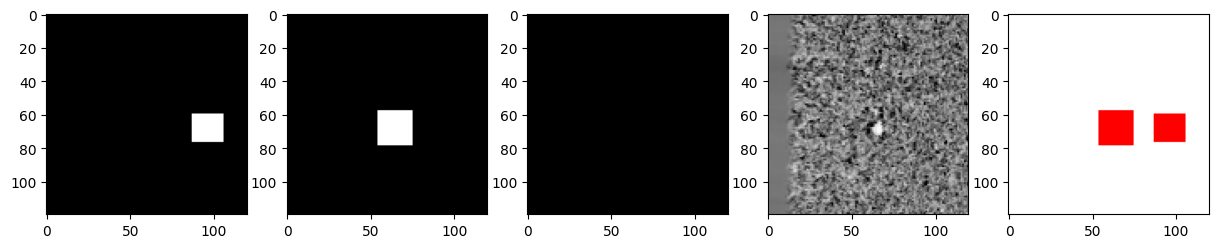

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(15,15))
axs[0].imshow(mask_20x20[1044:1164,1389:1509]*255, aspect=1)
axs[1].imshow(mask_30x30[1044:1164,1389:1509]*255, aspect=1)
axs[2].imshow(mask_40x40[1044:1164,1389:1509]*255, aspect=1)
axs[3].imshow(np.flip(rotated_image[1044:1164,1389:1509], axis=1), aspect=1)
axs[4].imshow(mask_3combined[1044:1164,1389:1509], aspect=1)

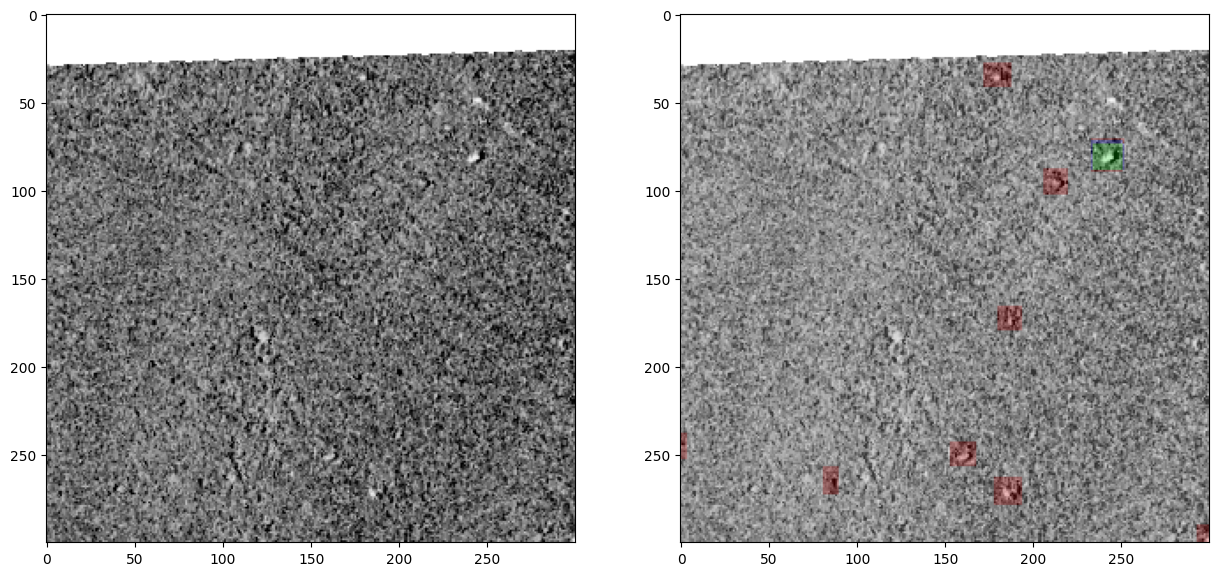

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(15,15))
a=1700
b=2000

axs[0].imshow(rotated_image[550:850,a:b,:], aspect=1)
#axs[0].imshow(mask_20x20[550:850,a:b,:]*255, aspect=1, alpha=0.5)

axs[1].imshow(rotated_image[550:850,a:b,:], aspect=1)
axs[1].imshow(mask_3combined[550:850,a:b,:], aspect=1, alpha=0.2)

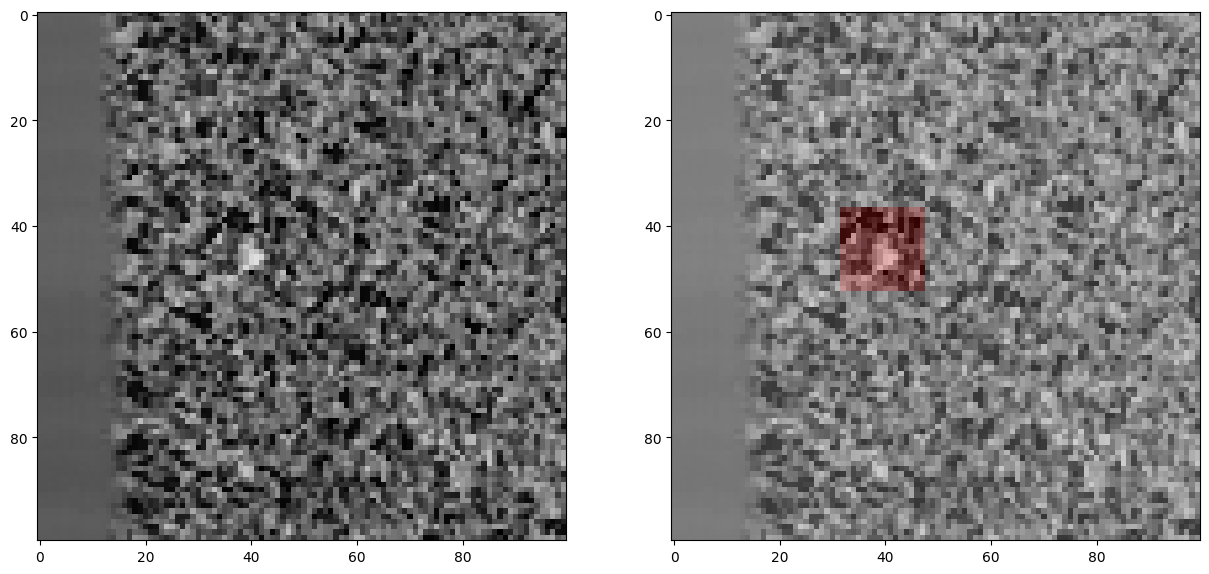

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(15,15))

axs[0].imshow(rotated_image[1050:1150, 4450:4550,:], aspect=1)
#axs[0].imshow(mask_20x20[550:850,a:b,:]*255, aspect=1, alpha=0.5)

axs[1].imshow(rotated_image[1050:1150, 4450:4550,:], aspect=1)
axs[1].imshow(mask_3combined[1050:1150, 4450:4550,:], aspect=1, alpha=0.2)

##MEASURING BOULDER'S HEIGHT

Load previously trained model

In [21]:
detect_shadow_model_n = YOLO(os.path.join(semantic_segmentation_path, 'YOLOv8', 'boulder_height', 'yolov8n_model_iou06_200epoch_2', 'weights', 'best.pt'))
detect_shadow_model_m = YOLO(os.path.join(semantic_segmentation_path, 'YOLOv8', 'boulder_height', 'yolov8m_model_iou06_200epoch_imgsz50)', 'weights', 'best.pt'))

In [29]:
print(boxes_20x20_right[4])
print(boxes_20x20_right[5])
print(boxes_20x20_right[6])
print(boxes_20x20_right[7])

4482.9985
1087.9496
4498.53
1103.9409


Predict shadow of boulder

In [72]:
boulder_image = rotated_image[int(boxes_20x20_right[5]):int(boxes_20x20_right[7]), int(boxes_20x20_right[4]):int(boxes_20x20_right[6])]

results = detect_shadow_model_m.predict(source=boulder_image, save=True, save_txt=True, iou=0.2, conf=0.5, show_labels=False,
                                      project='/content/drive/MyDrive/data/semantic_segmentation/YOLOv8/boulder_height/prediction',
                                      name='yolov8_boulder_iou0.2_conf0.5_')


0: 64x64 1 shadow, 19.2ms
Speed: 0.7ms preprocess, 19.2ms inference, 3.1ms postprocess per image at shape (1, 3, 64, 64)
Results saved to /content/drive/MyDrive/data/semantic_segmentation/YOLOv8/boulder_height/prediction/yolov8_boulder_iou0.2_conf0.5_2
1 label saved to /content/drive/MyDrive/data/semantic_segmentation/YOLOv8/boulder_height/prediction/yolov8_boulder_iou0.2_conf0.5_2/labels


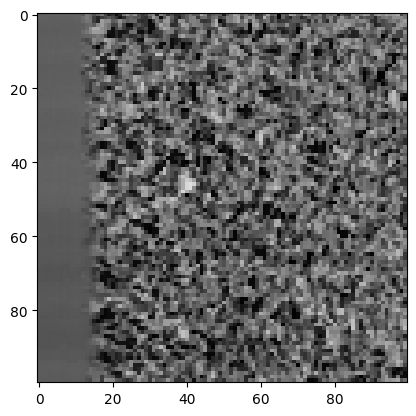

In [37]:
plt.imshow(rotated_image[1050:1150, 4450:4550])

In [70]:
a = int(boxes_20x20_right[4])
b = int(boxes_20x20_right[5])
c = int(boxes_20x20_right[6])
d = int(boxes_20x20_right[7])
print(a)
print(b)
print(c)
print(d)

4482
1087
4498
1103


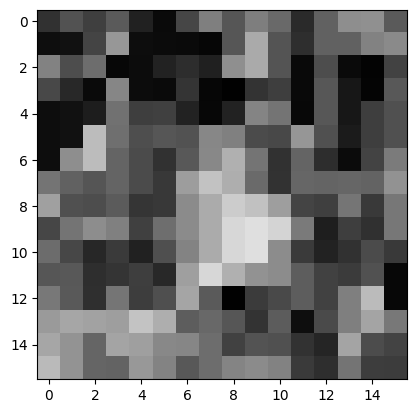

In [71]:
plt.imshow(rotated_image[b:d, a:c])

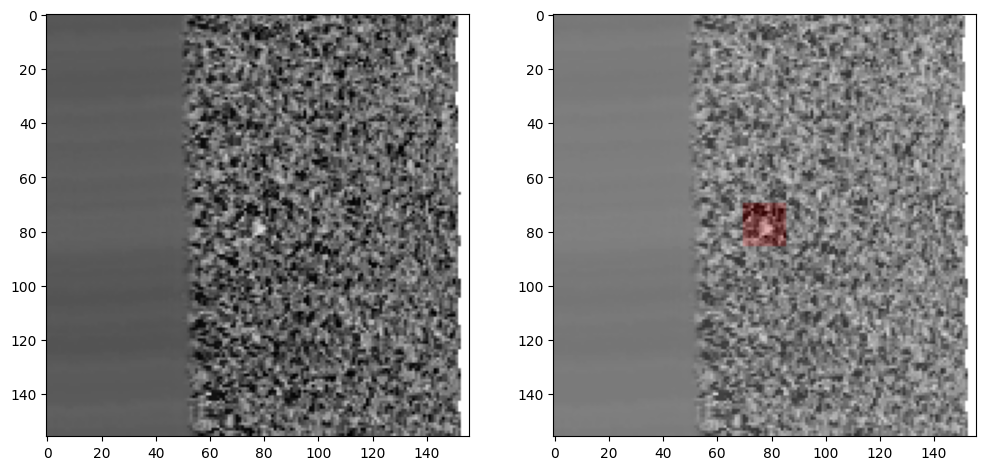

In [69]:
#plt.imshow(rotated_image[int(boxes_20x20_right[13])-70:int(boxes_20x20_right[15])+70, int(boxes_20x20_right[12])-70:int(boxes_20x20_right[14])+70])

fig, axs = plt.subplots(1, 2, figsize=(12,12))

axs[0].imshow(rotated_image[int(boxes_20x20_right[5])-70:int(boxes_20x20_right[7])+70, int(boxes_20x20_right[4])-70:int(boxes_20x20_right[6])+70], aspect=1)
#axs[0].imshow(mask_20x20[550:850,a:b,:]*255, aspect=1, alpha=0.5)

axs[1].imshow(rotated_image[int(boxes_20x20_right[5])-70:int(boxes_20x20_right[7])+70, int(boxes_20x20_right[4])-70:int(boxes_20x20_right[6])+70], aspect=1)
axs[1].imshow(mask_3combined[int(boxes_20x20_right[5])-70:int(boxes_20x20_right[7])+70, int(boxes_20x20_right[4])-70:int(boxes_20x20_right[6])+70, :], aspect=1, alpha=0.2)

##CREATING DATASET PIPELINE TO USE FOR KERAS

In [ ]:
!pip install --upgrade git+https://github.com/keras-team/keras-cv -q

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.1/880.1 kB 5.6 MB/s eta 0:00:00


In [ ]:
import keras_cv
from keras_cv import bounding_box
from keras_cv import visualization

Using TensorFlow backend


In [ ]:
BATCH_SIZE = 32
LEARNING_RATE = 0.001
EPOCH = 50
GLOBAL_CLIPNORM = 10.0

In [ ]:
class_ids = [
    "bicycle",
    "car",
    "airplane",
    "bus",
    "train",
    "boat",
    "traffic light",
    "fire hydrant",
    "stop sign",
    "parking meter",
    "bench",
    "bird",
    "cat",
    "dog",
    "boulder"
]

class_mapping = dict(zip(range(len(class_ids)), class_ids))

# Path to images and annotations
path_images = os.path.join(object_detection_path, 'tiles_for_train', '50x50', 'Baltic_Sea', 'images', 'train')
path_annot = os.path.join(object_detection_path, 'tiles_for_train', '50x50', 'Baltic_Sea', 'labels', 'train')

path_images_val = os.path.join(object_detection_path, 'tiles_for_train', '50x50', 'Baltic_Sea', 'images', 'val')
path_annot_val = os.path.join(object_detection_path, 'tiles_for_train', '50x50', 'Baltic_Sea', 'labels', 'val')

# Get all TXT file paths in path_annot and sort them
txt_files = sorted(
    [
        os.path.join(path_annot, file_name)
        for file_name in os.listdir(path_annot)
        if file_name.endswith(".txt")
    ]
)

txt_files_val = sorted(
    [
        os.path.join(path_annot_val, file_name)
        for file_name in os.listdir(path_annot_val)
        if file_name.endswith(".txt")
    ]
)


# Get all PNG image file paths in path_images and sort them
png_files = sorted(
    [
        os.path.join(path_images, file_name)
        for file_name in os.listdir(path_images)
        if file_name.endswith(".png")
    ])

png_files_val = sorted(
    [
        os.path.join(path_images_val, file_name)
        for file_name in os.listdir(path_images_val)
        if file_name.endswith(".png")
    ])


In [ ]:
# create an empty list
bbox = []
classes = []
images_paths = []

# open the txt file in read mode
for txt_file in tqdm(txt_files):
  with open(txt_file, "r") as f:
    boxes= []
    class_ids = []
    # loop through each line in the file
    for line in f:
      # strip the newline character and append the line to the list
      class_ids.append(int(float(line.strip().split(" ")[0])))
      boxes.append([float(x)*200 for x in line.strip().split(" ")[1:]])
    classes.append(class_ids)
    bbox.append(boxes)

for png_file in tqdm(png_files):
  images_paths.append(png_file)

# create an empty list
bbox_val = []
classes_val = []
images_paths_val = []

# open the txt file in read mode
for txt_file in tqdm(txt_files_val):
  with open(txt_file, "r") as f:
    boxes= []
    class_ids = []
    # loop through each line in the file
    for line in f:
      # strip the newline character and append the line to the list
      class_ids.append(int(float(line.strip().split(" ")[0])))
      boxes.append([float(x)*200 for x in line.strip().split(" ")[1:]])
    classes_val.append(class_ids)
    bbox_val.append(boxes)

for png_file in tqdm(png_files_val):
  images_paths_val.append(png_file)

  0%|          | 0/1009 [00:00<?, ?it/s]

  0%|          | 0/1009 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

  0%|          | 0/155 [00:00<?, ?it/s]

In [ ]:
bbox = tf.ragged.constant(bbox)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(images_paths)

bbox_val = tf.ragged.constant(bbox_val)
classes_val = tf.ragged.constant(classes_val)
image_paths_val = tf.ragged.constant(images_paths_val)

train_data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))
val_data = tf.data.Dataset.from_tensor_slices((image_paths_val, classes_val, bbox_val))

In [ ]:
def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image


def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

In [ ]:
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)

val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)

In [ ]:
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=5,
        font_scale=0.7,
        bounding_box_format=bounding_box_format,
        class_mapping=class_mapping,
    )


visualize_dataset(
    train_ds, bounding_box_format="center_xywh", value_range=(0, 255), rows=2, cols=2
)

visualize_dataset(
      val_ds, bounding_box_format="center_xywh", value_range=(0, 255), rows=2, cols=2
)

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]


train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_xs_backbone_coco"  # We will use yolov8 small backbone with coco weights, this is the equivalent to yolov8n from pytorch
)

5347160/5347160 [==============================] - 0s 0us/step


In [ ]:
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="center_xywh",
    backbone=backbone,
    fpn_depth=1,
)

In [ ]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)

In [ ]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="center_xywh",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs

In [ ]:
yolo.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    callbacks=[EvaluateCOCOMetricsCallback(val_ds, "YOLOv8_Keras_10epoch.h5")],
)

Epoch 1/10


TypeError: ignored

In [ ]:
def visualize_detections(model, dataset, bounding_box_format):
    images, y_true = next(iter(dataset.take(1)))
    y_pred = model.predict(images)
    y_pred = bounding_box.to_ragged(y_pred)
    visualization.plot_bounding_box_gallery(
        images,
        value_range=(0, 255),
        bounding_box_format=bounding_box_format,
        y_true=y_true,
        y_pred=y_pred,
        scale=4,
        rows=2,
        cols=2,
        show=True,
        font_scale=0.7,
        class_mapping=class_mapping,
    )


visualize_detections(yolo, dataset=val_ds, bounding_box_format="center_xywh")

##Testing YoloV5 PyTorch

In [ ]:
!pip install torch==1.8.1+cu111 torchvision==0.9.1+cu111 torchaudio===0.8.1 -f https://download.pytorch.org/whl/lts/1.8/torch_lts.html
!git clone https://github.com/ultralytics/yolov5
!cd yolov5 && pip install -r requirements.txt

In [ ]:
import torch
from matplotlib import pyplot as plt
import numpy as np
import cv2
import os

In [ ]:
!cd yolov5 && python train.py --img 100 --batch 64 --epochs 100 --data yaml-beautifier.yaml --weights yolov5s.pt

train: weights=yolov5s.pt, cfg=, data=yaml-beautifier.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=100, batch_size=64, imgsz=100, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, seed=0, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v7.0-202-gf9f023a Python-3.10.12 torch-2.0.1+cu118 CUDA:0 (Tesla T4, 15102MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s=0.7, h

In [ ]:
model = torch.hub.load('ultralytics/yolov5', 'custom', path='yolov5/runs/train/exp4/weights/last.pt', force_reload=True)

/usr/local/lib/python3.10/dist-packages/torch/hub.py:286: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/ultralytics/yolov5/zipball/master" to /root/.cache/torch/hub/master.zip
WARNING ⚠️ 'ultralytics.yolo.v8' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use 'ultralytics.models.yolo' instead.
WARNING ⚠️ 'ultralytics.yolo.utils' is deprecated since '8.0.136' and will be removed in '8.1.0'. Please use

##Testing KERAS

In [ ]:
!pip install --upgrade git+https://github.com/keras-team/keras-cv

  Cloning https://github.com/keras-team/keras-cv to /tmp/pip-req-build-qtmcnhbk
  Running command git clone --filter=blob:none --quiet https://github.com/keras-team/keras-cv /tmp/pip-req-build-qtmcnhbk
  Resolved https://github.com/keras-team/keras-cv to commit 90ccc1f501444597fe29a7b5b537d8d33c03153f
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.1/753.1 kB 6.2 MB/s eta 0:00:00
  Created wheel for keras-cv: filename=keras_cv-0.6.1-py3-none-any.whl size=760830 sha256=946b5c313af1b030c79dbfe3fdee29ec6cc741d964f5dfb1afa4d0d5b13fd0a2
  Stored in directory: /tmp/pip-ephem-wheel-cache-uyzo0f5_/wheels/35/f2/a0/a17d87e8d0bfd3f36a4f092213fb8f0bd8b1a87cebcec85de2
Successfully built keras-cv


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
import keras_cv
import numpy as np
from keras_cv import bounding_box
import os
import resource
from keras_cv import visualization
import tqdm

Using TensorFlow backend


In [ ]:
train_ds, ds_info = your_data_loader.load(
    split='train', bounding_box_format='xywh', batch_size=8
)

##Testing Detecto from PyTorch

In [ ]:
import torch

In [ ]:
!pip install detecto

In [ ]:
from detecto import core, utils, visualize
from detecto.visualize import show_labeled_image, plot_prediction_grid
from torchvision import transforms
import matplotlib.pyplot as plt
import numpy as np
import os

In [ ]:
Train_dataset=core.Dataset(os.path.join('drive', 'MyDrive', 'data', 'object_detection', 'train'))#L1
Test_dataset = core.Dataset(os.path.join('drive', 'MyDrive', 'data', 'object_detection', 'test'))#L2
loader=core.DataLoader(Train_dataset, batch_size=2, shuffle=True)#L3
model = core.Model(['boulder'])#L4
losses = model.fit(loader, Test_dataset, epochs=25, lr_step_size=5, learning_rate=0.001, verbose=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 329MB/s]


Epoch 1 of 25
Begin iterating over training dataset


100%|██████████| 7/7 [00:11<00:00,  1.71s/it]


Begin iterating over validation dataset


100%|██████████| 6/6 [00:01<00:00,  3.44it/s]


Loss: 0.6652757128079733
Epoch 2 of 25
Begin iterating over training dataset


100%|██████████| 7/7 [00:02<00:00,  2.95it/s]


Begin iterating over validation dataset


100%|██████████| 6/6 [00:00<00:00,  9.76it/s]


Loss: 0.8874639272689819
Epoch 3 of 25
Begin iterating over training dataset


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


Begin iterating over validation dataset


100%|██████████| 6/6 [00:00<00:00,  9.28it/s]


Loss: 0.7833456695079803
Epoch 4 of 25
Begin iterating over training dataset


100%|██████████| 7/7 [00:02<00:00,  2.89it/s]


Begin iterating over validation dataset


100%|██████████| 6/6 [00:00<00:00,  9.65it/s]


Loss: 0.7667005658149719
Epoch 5 of 25
Begin iterating over training dataset


100%|██████████| 7/7 [00:02<00:00,  2.90it/s]


Begin iterating over validation dataset


100%|██████████| 6/6 [00:00<00:00,  9.71it/s]


Loss: 0.7605734070142111
Epoch 6 of 25
Begin iterating over training dataset


100%|██████████| 7/7 [00:02<00:00,  2.88it/s]


Begin iterating over validation dataset


100%|██████████| 6/6 [00:00<00:00,  9.67it/s]


Loss: 0.7486104667186737
Epoch 7 of 25
Begin iterating over training dataset


100%|██████████| 7/7 [00:02<00:00,  2.86it/s]


Begin iterating over validation dataset


100%|██████████| 6/6 [00:00<00:00,  9.13it/s]


Loss: 0.759096622467041
Epoch 8 of 25
Begin iterating over training dataset


100%|██████████| 7/7 [00:02<00:00,  2.81it/s]


Begin iterating over validation dataset


100%|██████████| 6/6 [00:00<00:00,  8.83it/s]


Loss: 0.7489440888166428
Epoch 9 of 25
Begin iterating over training dataset


100%|██████████| 7/7 [00:02<00:00,  2.74it/s]


Begin iterating over validation dataset


100%|██████████| 6/6 [00:00<00:00,  9.39it/s]


Loss: 0.7413786798715591
Epoch 10 of 25
Begin iterating over training dataset


100%|██████████| 7/7 [00:02<00:00,  2.84it/s]


Begin iterating over validation dataset


100%|██████████| 6/6 [00:00<00:00,  9.44it/s]


Loss: 0.7387630691130956
Epoch 11 of 25
Begin iterating over training dataset


100%|██████████| 7/7 [00:02<00:00,  2.69it/s]


Begin iterating over validation dataset


100%|██████████| 6/6 [00:00<00:00,  8.67it/s]


Loss: 0.7435954908529917
Epoch 12 of 25
Begin iterating over training dataset


100%|██████████| 7/7 [00:02<00:00,  2.73it/s]


Begin iterating over validation dataset


100%|██████████| 6/6 [00:00<00:00,  8.91it/s]


Loss: 0.7355358203252157
Epoch 13 of 25
Begin iterating over training dataset


100%|██████████| 7/7 [00:02<00:00,  2.72it/s]


Begin iterating over validation dataset


100%|██████████| 6/6 [00:00<00:00,  9.21it/s]


Loss: 0.7480507145325342
Epoch 14 of 25
Begin iterating over training dataset


100%|██████████| 7/7 [00:02<00:00,  2.79it/s]


Begin iterating over validation dataset


100%|██████████| 6/6 [00:00<00:00,  9.25it/s]


Loss: 0.753661091128985
Epoch 15 of 25
Begin iterating over training dataset


100%|██████████| 7/7 [00:02<00:00,  2.77it/s]


Begin iterating over validation dataset


100%|██████████| 6/6 [00:00<00:00,  9.31it/s]


Loss: 0.7449776331583658
Epoch 16 of 25
Begin iterating over training dataset


100%|██████████| 7/7 [00:02<00:00,  2.76it/s]


Begin iterating over validation dataset


100%|██████████| 6/6 [00:00<00:00,  8.65it/s]


Loss: 0.7431367337703705
Epoch 17 of 25
Begin iterating over training dataset


100%|██████████| 7/7 [00:02<00:00,  2.71it/s]


Begin iterating over validation dataset


100%|██████████| 6/6 [00:00<00:00,  8.99it/s]


Loss: 0.7491698662439982
Epoch 18 of 25
Begin iterating over training dataset


100%|██████████| 7/7 [00:02<00:00,  2.79it/s]


Begin iterating over validation dataset


100%|██████████| 6/6 [00:00<00:00,  9.35it/s]


Loss: 0.7430427819490433
Epoch 19 of 25
Begin iterating over training dataset


100%|██████████| 7/7 [00:02<00:00,  2.80it/s]


Begin iterating over validation dataset


100%|██████████| 6/6 [00:00<00:00,  9.40it/s]


Loss: 0.7344067295392355
Epoch 20 of 25
Begin iterating over training dataset


100%|██████████| 7/7 [00:02<00:00,  2.82it/s]


Begin iterating over validation dataset


100%|██████████| 6/6 [00:00<00:00,  9.47it/s]


Loss: 0.7511170506477356
Epoch 21 of 25
Begin iterating over training dataset


100%|██████████| 7/7 [00:02<00:00,  2.79it/s]


Begin iterating over validation dataset


100%|██████████| 6/6 [00:00<00:00,  9.11it/s]


Loss: 0.7477811177571615
Epoch 22 of 25
Begin iterating over training dataset


100%|██████████| 7/7 [00:02<00:00,  2.81it/s]


Begin iterating over validation dataset


100%|██████████| 6/6 [00:00<00:00,  9.46it/s]


Loss: 0.7382083584864935
Epoch 23 of 25
Begin iterating over training dataset


100%|██████████| 7/7 [00:02<00:00,  2.83it/s]


Begin iterating over validation dataset


100%|██████████| 6/6 [00:00<00:00,  9.59it/s]


Loss: 0.7450531621774038
Epoch 24 of 25
Begin iterating over training dataset


100%|██████████| 7/7 [00:02<00:00,  2.76it/s]


Begin iterating over validation dataset


100%|██████████| 6/6 [00:00<00:00,  9.36it/s]


Loss: 0.7331384619077047
Epoch 25 of 25
Begin iterating over training dataset


100%|██████████| 7/7 [00:02<00:00,  2.83it/s]


Begin iterating over validation dataset


100%|██████████| 6/6 [00:00<00:00,  9.27it/s]

Loss: 0.7640152672926585


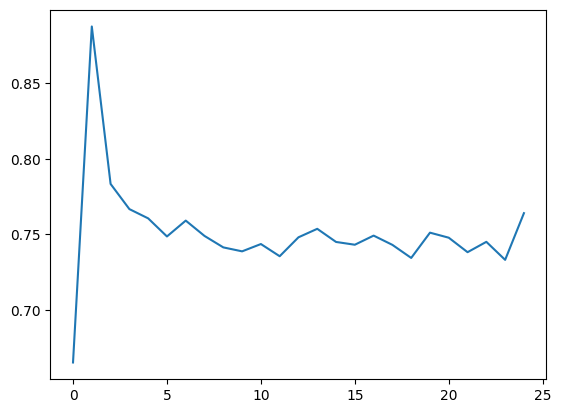

In [ ]:
plt.plot(losses)

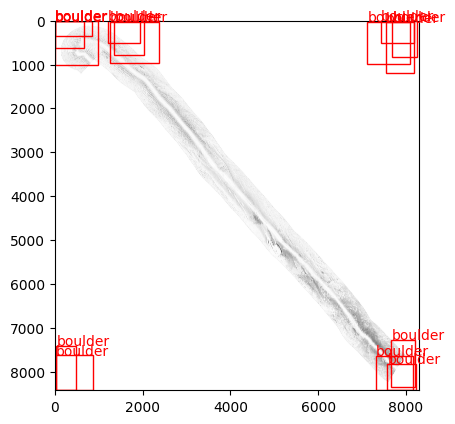

In [ ]:
image = utils.read_image(os.path.join('drive', 'MyDrive', 'data', 'geotiff', 'Line04_greys.tif'))
predictions = model.predict(image)
labels, boxes, scores = predictions
show_labeled_image(image, boxes, labels)

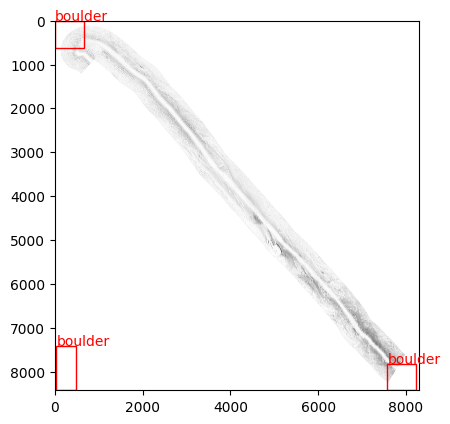

In [ ]:
thresh=0.1
filtered_indices=np.where(scores>thresh)
filtered_scores=scores[filtered_indices]
filtered_boxes=boxes[filtered_indices]
num_list = filtered_indices[0].tolist()
filtered_labels = [labels[i] for i in num_list]
show_labeled_image(image, filtered_boxes, filtered_labels)